## Classification of Hand Gestures

In this notebook, we train and evaluate different classification models for the task of hand gesture classification. We use the data generated in the previous notebook.

### Setup

---

To reload custom scripts automatically:

In [1]:
%load_ext autoreload
%autoreload 2

Define dependencies:

In [2]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import signal

# Modelling
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold



import os
import time
import copy
import pickle
from tqdm import tqdm
import random
import sys
sys.path.insert(0, '../')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from src import utils

Define global variables:

In [3]:
DATA_ROOT = os.path.join("..", "data")
NINAPRO_ROOT = os.path.join("..", "data", "ninapro")
SAMPLING_EMG_RATE = 100
USE_REP = False # Wther to use the repetition as a window or not

### Load the data preprocessed in the previous notebook

---

Before loading the data, make sure you downloaded them ([link](https://drive.google.com/file/d/1tz8tb6rruNvnlBkwDc80aT7D8jAXvwkF/view?usp=sharing)) and placed them into the data folder! 

We start by loading the data preprocessed in the previous notebook.

In [4]:
filename = "exercise_1_wind_processed.pkl" if USE_REP else "exercise_1_processed.pkl"
with open(os.path.join(DATA_ROOT, filename), 'rb') as file:
    subjects_features = pickle.load(file)

print("✅ Successfully loaded data, there are {} subjects.".format(len(subjects_features)))

✅ Successfully loaded data, there are 27 subjects.


Now, let's check what we get for instance for first subject:

In [5]:
# Get the data for the first subject
X_train, y_train, X_val, y_val, X_test, y_test = subjects_features[1]

# Print the shapes of the data
print(f"ℹ️ Number of windows: {X_train.shape[0]} (train), {X_val.shape[0]} (val), {X_test.shape[0]} (test)")
print(f"ℹ️ All have {X_train.shape[1]} features.")

ℹ️ Number of windows: 2004 (train), 1239 (val), 778 (test)
ℹ️ All have 100 features.


### Train and Eval the Models - train and eval on the same subject

---

In this section, we try to train and then evaluate the model on the data from 10 subjects. Note that these subjeocts will remain same for training as well as validation. We will train separate models for each subject and then evaluate them on the test data of the same subject.

In [ ]:
# Set the random seed
np.random.seed(42)

# Select randmly 10 subjects
selected_subjects = np.random.choice(list(subjects_features.keys()), 10, replace=False)

# Collect the data for the selected subjects
selected = dict()
for subject in selected_subjects:
    # Get the data for the subject
    X_train, y_train, X_val, y_val, X_test, y_test = subjects_features[subject]

    # Shuffle the data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Add the data to the dictionary
    selected[subject] = (X_train, y_train, X_val, y_val, X_test, y_test)

Next, we define our models to be trained:

In [ ]:
# Logistic regression optimised via SGD 
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic regression', SGDClassifier(loss="log_loss", penalty="l2", max_iter=100, warm_start=False))
])

# SVM with RBF kernel
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1, gamma=1e-4))
])

# K nearest neighbours
knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Random forest
rf = Pipeline([
    ('scaler', StandardScaler()),  
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, warm_start=False))
])


# Collect the models in a dictionary
models = {
    "Logistic regression": lr,
    "SVM": svc,
    "KNN": knn,
    "Random forest": rf,
}

Now, train each model and evaluate it on validation data:

In [ ]:
# Define the dictionary to store the results
results = dict()

for model_name, model in models.items():

    # Define the dictionary to store the results
    results[model_name] = dict()

    for subject in selected.keys():

        # Get the data for training and evaluation
        X_train, y_train, X_val, y_val, _, _ = selected[subject]

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model on training and validation data
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Compute the accuracy
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        # Store the results
        results[model_name][subject] = {
            "train_pred": y_train_pred,
            "train_acc": train_acc,
            "val_pred": y_val_pred,
            "val_acc": val_acc
        }

        # Compute the feature importance for logistic regression
        if model_name == "Logistic regression":
            # Compute the feature importance
            r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=42, scoring="accuracy")

            # Store the results
            results[model_name][subject]["importances_mean"] = r.importances_mean
            results[model_name][subject]["importances_std"] = r.importances_std
    
    # Compute the mean and std of the results
    train_acc = np.array([results[model_name][subject]["train_acc"] for subject in selected.keys()])
    val_acc = np.array([results[model_name][subject]["val_acc"] for subject in selected.keys()])

    train_mean, train_std = train_acc.mean(), train_acc.std()
    val_mean, val_std = val_acc.mean(), val_acc.std()

    # Print the 95 % confidence interval
    traincf = 1.96 * train_std / np.sqrt(len(selected.keys()))
    valcf = 1.96 * val_std / np.sqrt(len(selected.keys()))
    print(f"🤖 {model_name}:")
    print(f"ℹ️ Train: {train_mean:.3f} ± {traincf:.3f}")
    print(f"🚨 Val: {val_mean:.3f} ± {valcf:.3f}\n")


Now, let's collect the results into a dataframe:

In [ ]:
results_df = pd.DataFrame(columns=["model", "subject", "train_acc", "val_acc"])

for model_name, model in models.items():
    for subject in selected.keys():
        train_acc = results[model_name][subject]["train_acc"]
        val_acc = results[model_name][subject]["val_acc"]

        new_row = pd.DataFrame({
            "model": model_name,
            "subject": subject,
            "train_acc": train_acc,
            "val_acc": val_acc
        }, columns=["model", "subject", "train_acc", "val_acc"], index=[0])

        results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.sort_values(by=["val_acc"], inplace=False, ascending=False).head(10)

Some models definitely look promising! Clearly many of them overfit the data which is a matter of adjusting the regularization parameters. We will do that later. For now, let's dive into the details of evaluation of feauture importances. For that, we will use permutation importance [more details](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance). In simple terms, for given number of times `K`, we shuffle the value of a feature and then evaluate the model's performance. In our case, we use accuracy. The difference between the original accuracy and the accuracy after shuffling the feature is the importance of that feature. We do this for all the features. Finally, we average the importance of each feature over `K` iterations. This gives us the final importance of each feature. 

In [ ]:
# Collect feature importances for all subjects
importances = dict()
for subject in selected.keys():
    importances[subject] = results["Logistic regression"][subject]["importances_mean"]

# Turn the dictionary into a dataframe
importances_df = pd.DataFrame(importances)
assert importances_df.shape[1] == 10, "❌ There should be 10 subjects."
assert importances_df.shape[0] == 100, "❌ There should be 100 features."

# Compute correlation matrix accross subjects
corr = importances_df.corr()

# Plot the correlation matrix using seaborn
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation', 'orientation': 'horizontal'});

# Make the ticks larger
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12);

# Set the fontsize of colorbar label to 14
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xlabel("Correlation", fontsize=14)

# Set the labels
ax.set_ylabel("Subject", fontsize=14);

# Save the figure
fig.savefig(os.path.join("..", "figures", "corr_matrix.png"), dpi=300, bbox_inches='tight')

Now, let's plot the feature importances for each model using heatmap:

In [ ]:
# Setup the figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(data=importances_df.T, cmap="coolwarm", ax=ax, cbar_kws={'label': 'Feature importance', 'orientation': 'horizontal'});

# Reduce the number of xticks
ax.set_xticks(np.arange(0, 105, 5));
ax.set_xticklabels(np.arange(0, 105, 5));

# Make the ticks larger
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12);

# Set the fontsize of colorbar label to 14
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xlabel("Feature importance (Permutation Based)", fontsize=14)

# Set the labels
ax.set_ylabel("Subject", fontsize=14);

# Save the figure
fig.savefig(os.path.join("..", "figures", "feature_importance.png"), dpi=300, bbox_inches="tight")


We can see that in general, first 50 features are most important accross all the subjects. Finally, we will use grid search to find the best hyperparameters for the model. Let's start by defining the models and hyper-parameters to grid search over:

In [7]:
# Define models
pipelines = {
    "lr" : Pipeline([
        ('scaler', StandardScaler()),
        ('lr', SGDClassifier())
    ]),
    "knn" : Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    "rf" : Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier())
    ])
}

# Define hyperparameters
hyperparameters = {
    "lr" : {
        "lr__loss" : ["log", "hinge"],
        "lr__penalty" : ["l1", "l2"],
        "lr__alpha" : [0.0001, 0.001, 0.01, 0.1],
        "lr__max_iter" : [100, 200, 300, 400, 500]
    },
    "knn" : {
        "knn__n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15],
        "knn__weights" : ["uniform", "distance"],
        "knn__metric" : ["euclidean", "manhattan"]
    },
    "rf" : {
        "rf__n_estimators" : [100, 200, 300, 400, 500],
        "rf__max_depth" : [1, 3, 5, 7, 9, 11, 13, 15],
        "rf__max_features" : ["auto", "sqrt", "log2"]
    }
}

Next, run the hyper-parameter tuning:

In [8]:
path = os.path.join(DATA_ROOT, "hyptun_analysis_p1.pkl")

# Load the finetuning results
if os.path.exists(path):
    with open(path, "rb") as f:
        results_tuning = pickle.load(f)
        selected_ids = list(set([k[0] for k in results_tuning.keys()]))
        selected = dict()
        for subject in selected_ids:
             selected[subject] = subjects_features[subject]

# Run the finetuning - takes around one hour
else:
    # Define the dictionary to store the results
    results_tuning = dict()

    # Loop over the models
    for subject in tqdm(selected.keys()):

        # Get the data for training and evaluation
        X_train, y_train, X_val, y_val, _, _ = selected[subject]

        # Concat the training and validation data
        X = np.concatenate([X_train, X_val], axis=0)
        y = np.concatenate([y_train, y_val], axis=0)

        # Shuffle the data
        X, y = shuffle(X, y, random_state=42)

        for name, pipeline in pipelines.items():

            # Grid search
            grid_search = GridSearchCV(pipeline, hyperparameters[name], cv=5, scoring='accuracy', n_jobs=6)
            grid_search.fit(X, y)

            # Store the results
            results_tuning[(subject, name)] = {
                "best_params": grid_search.best_params_,
                "best_score": grid_search.best_score_,
                "best_estimator": grid_search.best_estimator_
            }

    # Save the results 
    with open(path, "wb") as f:
        pickle.dump(results_tuning, f)

Next, for each subject, select the best model, and compute the train, val and test accuracy:

In [9]:
# Store the results for each split
splits_results = {"test": []}

for subject in selected.keys():

    # Get the best model for the given subject
    best_score = 0
    best_model = None
    for name in pipelines.keys():
        score = results_tuning[(subject, name)]["best_score"]
        if score > best_score:
            best_score = score
            best_model = results_tuning[(subject, name)]["best_estimator"]
    
    # Get the data for training and evaluation
    _, _, _, _, X_test, y_test = selected[subject]

    # Compute the accuracy
    y_test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store the results
    splits_results["test"].append(test_acc)

# Compute the mean and std of the results
test_acc = np.array(splits_results["test"])
test_mean, test_std = test_acc.mean(), test_acc.std()

# Print the 95 % confidence interval
testcf = 1.96 * test_std / np.sqrt(len(selected.keys()))

print(f"🚀 Test: {test_mean:.3f} ± {testcf:.3f}\n")


🚀 Test: 0.815 ± 0.035



Not the best generalisation going from 93 % to 82 %, but with the exhaustive grid search, we managed to improve the mean accuracy by `5 %` to `81 %`. Now, let's create a dataframe where in rows we will have the models and in columns will we have the cross validation accuracy and test accuracy:

In [10]:
model_results = {model_name: {"test_acc": []} for model_name in pipelines.keys()}

for subject, model_name in results_tuning.keys():

    # Get the tuning result
    restun = results_tuning[(subject, model_name)]

    # Get best score
    best_score = restun["best_score"]

    # Get the testing data
    _, _, _, _, X_test, y_test = selected[subject]

    # Get the predictions
    y_test_pred = restun["best_estimator"].predict(X_test)

    # Compute the accuracy
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store the results
    model_results[model_name]["test_acc"].append(test_acc)

# Compute the mean and std of the results
df_tune_results = pd.DataFrame(columns=["model", "test_acc", "testcf"])
for model_name in pipelines.keys():
    test_acc = np.array(model_results[model_name]["test_acc"])

    test_mean, test_std = test_acc.mean(), test_acc.std()

    # Store the results
    new_row = pd.DataFrame({
        "model": model_name,
        "test_acc": test_mean,
        "testcf": 1.96 * test_std / np.sqrt(len(selected.keys())),
    }, columns=["model", "test_acc", "testcf"], index=[0])

    df_tune_results = pd.concat([df_tune_results, new_row], ignore_index=True)

# Round the results to 3 decimal places
df_tune_results = df_tune_results.round(3)

# Sort the results by test accuracy
df_tune_results = df_tune_results.sort_values(by=["test_acc"], inplace=False, ascending=False)

df_tune_results

,model,test_acc,testcf
2,rf,0.815,0.035
0,lr,0.737,0.042
1,knn,0.653,0.050


Let's quickly explore the best params accross all the models:

In [11]:
best_params = {
    "rf": {"max_depth": [], "max_features": [], "n_estimators": []},
    "knn": {"n_neighbors": [], "weights": [], "metric": []},
    "lr": {"loss": [], "penalty": [], "alpha": [], "max_iter": []},
}

for subject, model_name in results_tuning.keys():
        # Get the tuning result
        restun = results_tuning[(subject, model_name)]

        # Get best params
        s_best_params = restun["best_params"]
        
        # Only focus on rf
        if model_name == "rf":
            best_params["rf"]["max_depth"].append(s_best_params["rf__max_depth"])
            best_params["rf"]["max_features"].append(s_best_params["rf__max_features"])
            best_params["rf"]["n_estimators"].append(s_best_params["rf__n_estimators"])

        elif model_name == "knn": 
            best_params["knn"]["n_neighbors"].append(s_best_params["knn__n_neighbors"])
            best_params["knn"]["weights"].append(s_best_params["knn__weights"])
            best_params["knn"]["metric"].append(s_best_params["knn__metric"]) 

        elif model_name == "lr":
            best_params["lr"]["loss"].append(s_best_params["lr__loss"])
            best_params["lr"]["penalty"].append(s_best_params["lr__penalty"])
            best_params["lr"]["alpha"].append(s_best_params["lr__alpha"])
            best_params["lr"]["max_iter"].append(s_best_params["lr__max_iter"])

# For each model, get a dataframe from dictionary
df_best_params = dict()
for model_name in pipelines.keys():
    df_best_params[model_name] = pd.DataFrame(best_params[model_name])

# Now, we can easily inspect the best parameters for each model
# - KNN
n_nbs = int(df_best_params["knn"]["n_neighbors"].mean())
weights = df_best_params["knn"]["weights"].value_counts().index[0]
print(f"🤖 KNN (most optimal setup): n_neighbors={n_nbs}, weights={weights}")

# - Logistic regression
loss = df_best_params["lr"]["loss"].value_counts().index[0]
penalty = df_best_params["lr"]["penalty"].value_counts().index[0]
alpha = df_best_params["lr"]["alpha"].mean()
max_iter = int(df_best_params["lr"]["max_iter"].mean())
print(f"🤖 Logistic regression (most optimal setup): loss={loss}, penalty={penalty}, alpha={alpha}, max_iter={max_iter}")

# - Random forest
max_depth = int(df_best_params["rf"]["max_depth"].mean())
max_features = df_best_params["rf"]["max_features"].value_counts().index[0]
n_estimators = int(df_best_params["rf"]["n_estimators"].mean())
print(f"🤖 Random forest (most optimal setup): max_depth={max_depth}, max_features={max_features}, n_estimators={n_estimators}")

🤖 KNN (most optimal setup): n_neighbors=2, weights=distance
🤖 Logistic regression (most optimal setup): loss=hinge, penalty=l1, alpha=0.0001, max_iter=270
🤖 Random forest (most optimal setup): max_depth=15, max_features=sqrt, n_estimators=310


### General Model Building

---

In this section, we select `K` number of subjects and train the model on the data from these subjects. Then, we evaluate the model on the data from the remaining subjects. 

Let's start by defining the model to be trained:

In [12]:
# - No Grid Search approach
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth=15, max_features="sqrt", n_estimators=310))
])

Next, let's start by choosing randomly `7` subjects to be in our held out test set. Later, we will train the models on the varying number of subjects where our `K` will be 2, 4, 6, 8, 10, 12, 14, 16, 18. To account for the randomness, we will repeat this process `10` times.

In [13]:
# Get all subjects ids
subject_ids = list(subjects_features.keys())

# Set a seed value for reproducibility
seed_value = 42
np.random.seed(seed_value)

# Randomly select 7 subjects
test_subjects = np.random.choice(subject_ids, 7, replace=False)

# Get the ids of the remaining subjects
train_subjects = [s for s in subject_ids if s not in test_subjects]

# Collect the data for the selected subjects
X_test, y_test = utils.collect_subject_data(test_subjects, subjects_features)

# Show the shape of the test set
print(f"ℹ️ Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features.")
print(f"ℹ️ We have {len(test_subjects)} subjects in the test set and {len(train_subjects)} are available for training.")

ℹ️ Test set: 33125 samples, 100 features.
ℹ️ We have 7 subjects in the test set and 20 are available for training.


Next, let's train the model on the data from the remaining subjects and evaluate it on the test data:

In [18]:
# Define number of subjects to use for training
ks = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
nreps = 5 # Number of repetitions for each k

# Load the results if they exist
filename = "p2_results.pkl"
if os.path.exists(os.path.join(DATA_ROOT, filename)):
    print("🔁 Loading results...")
    with open(os.path.join(DATA_ROOT, filename), "rb") as f:
        p2_results = pickle.load(f)

# Otherwise, run the experiment
else:
    # Set a seed value for reproducibility
    seed_value = 42
    np.random.seed(seed_value)

    # Define the dictionary to store the results
    p2_results = dict()

    for k in ks:
        print(f"🔁 Running for k={k}...")
        for rep in range(1, nreps + 1):
            print(f"🔃 Running repetition {rep}...")
            start_time = time.time()

            # Select k subjects randomly
            selected_subjects = np.random.choice(train_subjects, k, replace=False)

            # Collect the data for the selected subjects
            X_train, y_train = utils.collect_subject_data(selected_subjects, subjects_features)
            print(f"ℹ️ Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features.")

            # Train the model
            best_model.fit(X_train, y_train)

            # Create a deep copy of the trained model
            best_model_copy = copy.deepcopy(best_model)

            # Compute the accuracy on test set
            y_test_pred = best_model_copy.predict(X_test)
            test_acc = accuracy_score(y_test, y_test_pred)

            # Store the results
            p2_results[(k, rep)] = {
                "best_params": best_model_copy.get_params(deep=True),
                "best_estimator": best_model_copy,
                "test_acc": test_acc
            }

            end_time = time.time()
            print(f"⏱️ Elapsed time: {end_time - start_time:.2f} seconds.\n")

    # Save the results
    with open(os.path.join(DATA_ROOT, filename), "wb") as f:
        pickle.dump(p2_results, f)

🔁 Loading results...


Let's inspect the results:

In [34]:
k_results = {k : {"test_acc": []} for k in ks}
df_results = pd.DataFrame(columns=["k", "rep", "test_acc"])
for k, rep in p2_results.keys():

    # Get the results
    res = p2_results[(k, rep)]

    # Get test acc
    test_acc = res["test_acc"]

    # Store the results
    k_results[k]["test_acc"].append(test_acc)

    # Store the results in a dataframe
    new_row = pd.DataFrame({
        "k": k,
        "rep": rep,
        "test_acc": test_acc
    }, columns=["k", "rep", "test_acc"], index=[0])

    df_results = pd.concat([df_results, new_row], ignore_index=True)

# Compute the mean and std of the results
df_k_results = pd.DataFrame(columns=["k", "test_acc", "testcf"])
for k in ks:
    test_acc = np.array(k_results[k]["test_acc"])

    test_mean, test_std = test_acc.mean(), test_acc.std()

    # Store the results
    new_row = pd.DataFrame({
        "k": k,
        "test_acc": test_mean,
        "testcf": 1.96 * test_std / np.sqrt(nreps),
    }, columns=["k", "test_acc", "testcf"], index=[0])

    df_k_results = pd.concat([df_k_results, new_row], ignore_index=True)

# Round the results to 3 decimal places
df_k_results = df_k_results.round(3)

# For both dfs exlude k=20
df_results = df_results[df_results["k"] != 20]
df_k_results = df_k_results[df_k_results["k"] != 20]

df_k_results

,k,test_acc,testcf
0,2,0.170,0.018
1,4,0.208,0.013
2,6,0.212,0.013
3,8,0.205,0.011
4,10,0.472,0.343
5,12,0.801,0.285
6,14,0.462,0.361
7,16,0.845,0.187
8,18,0.831,0.173


Nice! As we would expect the more subjects we use for training, the better the model generalises. However, notice the confidence interval, we have a high variance in performances, which shows that the performance depends a lot on how similar our training subjects are to the test subjects. Now, let's plot the results:

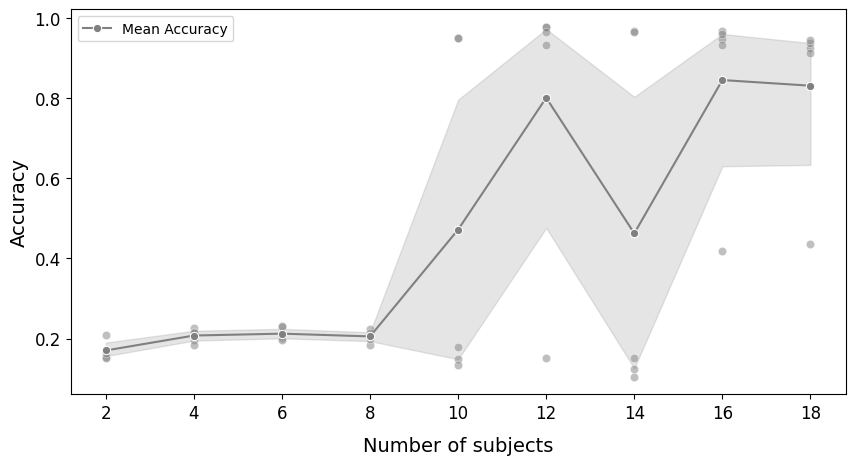

In [53]:
# Setup the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the results
sns.lineplot(data=df_results, x="k", y="test_acc", ax=ax, marker="o", color="grey", label="Mean Accuracy");

# Plot the data points
sns.scatterplot(data=df_results, x="k", y="test_acc", ax=ax, alpha=0.5, color="grey");

# Set the xticks
ax.set_xticks(ks[:-1]);

# Make the ticks larger
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12);


# Set the labels
ax.set_xlabel("Number of subjects", fontsize=14, labelpad=10);

# Set the fontsize of colorbar label to 14
ax.set_ylabel("Accuracy", fontsize=14);

---